# Flow Tracing from Velocity

This code is designed to map and model ablation stake locations over years

1. Import glacier outlines and velocities
2. Import glacier stake locations
3. Map stake locations in future years based on velocity field
4. Plot stake flow path and location in various years

In [1]:
import os, rasterio
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt

from raster_basics.RasterBasics import rOpen, rasterLike
from raster_basics.GlacierFunctions import demAspect, velocityAspect, velAspectDirection, particle_flow
from raster_basics.SmoothingFunctions import dynamicSmoothing
from raster_basics.DataPlots import plotData, velPlot


## Glacier outline and velocity filepath

In [2]:
# RGI OUTLINE
shp_file = '/Users/albinwells/Desktop/GlacierMB/Other/Gulkana_USGS_2021.shp'

# Gulkana ICE THICKNESS
thick_file = '/Users/albinwells/Desktop/GlacierMB/Gulkana/Gulkana_Thickness_Millan_clip.tif'

# Gulkana DEM
dem_file = '/Users/albinwells/Desktop/GlacierMB/Gulkana/RGI_GulkanaRegion_DEM_clip.tif'
dem_file = '/Users/albinwells/Desktop/GlacierMB/Gulkana/RGI60.01.00570_USGS_2m_DEM_filled.tif'

# OGGM CENTERLINE
shp_center = '/Users/albinwells/Desktop/GlacierMB/Other/RGI01_centerlines/RGI01_centerlines_corr_utm.shp'


In [3]:
# VELOCITY
folderpath = '/Users/albinwells/Desktop/GlacierMB/Gulkana/'
issm_fp = '/Users/albinwells/Desktop/docker-intermediary-folder/icepack_model_results/Downs_ISSM/'
n = 9
icepack_fp = '/Users/albinwells/Desktop/docker-intermediary-folder/icepack_model_results/Output' + str(n) + '/'

millan_vx_file = folderpath + '00570_MillanVelocity_2017-2018_vx.tif'
millan_vy_file = folderpath + '00570_MillanVelocity_2017-2018_vy.tif'
itslive_vx_file = folderpath + '00570_ITS_LIVE_2017-2018_vx.tif'
itslive_vy_file = folderpath + '00570_ITS_LIVE_2017-2018_vy.tif'
retreat_vx_file = folderpath + '00570_RETREAT_2017-2018_vx.tif'
retreat_vy_file = folderpath + '00570_RETREAT_2017-2018_vy.tif'
issm_vx_file = issm_fp + '00570_ISSM_Millan_utm_vx.tif'
issm_vy_file = issm_fp + '00570_ISSM_Millan_utm_vy.tif'
icepack_vx_file = icepack_fp + 'output' + str(n) + '_vx.tif'
icepack_vy_file = icepack_fp + 'output' + str(n) + '_vy.tif'


Smooth velocity input

In [4]:
raw_data_sf = 4 # smoothing factor for h and v files (factor*h is window size) -- recommend 4

# method 1 -- smooth v and derive vx and vy
glacier_v = (rOpen(millan_vx_file)**2 + rOpen(millan_vy_file)**2)**0.5
smooth_v = dynamicSmoothing(glacier_v, rOpen(thick_file), 20, raw_data_sf)


In [5]:
# separate velocity into x- and y- components based on velocity or DEM
aspect = velocityAspect(rOpen(millan_vx_file), rOpen(millan_vy_file))
# aspect = velocityAspect(-rOpen(itslive_vx_file), rOpen(itslive_vy_file))
# aspect = demAspect(rOpen(dem_file), 20)
# dem_smooth = dynamicSmoothing(rOpen(dem_file), rOpen(thick_file), 20, raw_data_sf)
# aspect = demAspect(dem_smooth, 20)

smooth_vx, smooth_vy = velAspectDirection(aspect, smooth_v)


In [6]:
# method 2 -- smooth vx and vy and derive v
# smooth_vx = dynamicSmoothing(rOpen(millan_vx_file), rOpen(thick_file), 20, raw_data_sf)
# smooth_vy = dynamicSmoothing(rOpen(millan_vy_file), rOpen(thick_file), 20, raw_data_sf)
# smooth_v = (smooth_vx**2 + smooth_vy**2)**0.5


In [7]:
# save smoothed files as rasters
smooth_vx_fp, smooth_vy_fp = 'temp_smooth_vx.tif', 'temp_smooth_vy.tif'
rasterLike(smooth_vx, smooth_vx_fp, millan_vx_file)
rasterLike(smooth_vy, smooth_vy_fp, millan_vy_file)


Quickly plot the velocity files

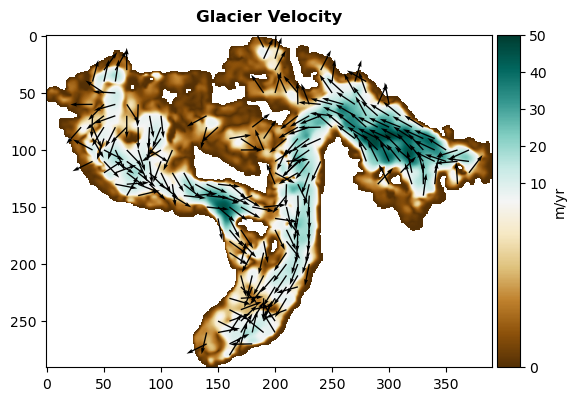

In [8]:
quiver_input = velPlot(rOpen(millan_vx_file), rOpen(millan_vy_file), glacier_v, 1e10, threshold=2)
plotData(glacier_v, cbarTitle='m/yr', color='BrBG', plotTitle='Glacier Velocity', quiver=quiver_input, 
         colorbarMin=0, colorbarMean=5, colorbarMax=50, savefig=False)

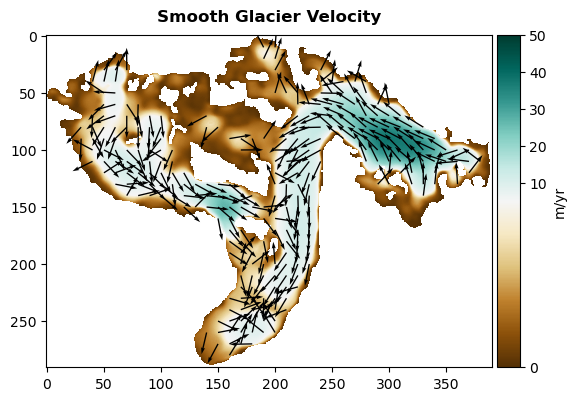

In [9]:
smooth_quiver = velPlot(smooth_vx, smooth_vy, smooth_v, 1e10, threshold=2)
plotData(smooth_v, cbarTitle='m/yr', color='BrBG', plotTitle='Smooth Glacier Velocity', quiver=smooth_quiver, 
         colorbarMin=0, colorbarMean=5, colorbarMax=50, savefig=False)


## Select files and stake locations

Sample of long-term stake positions

In [10]:
# Year Sampled, Season Sampled, Stake Year, Stake, Stake Height, Easting, Northing, Elevation
test_d1 = (2023, 'Fall', 2014, 'D', 4.57, 580642.331, 7018580.8, 1806.785)
test_d2 = (2022, 'Fall', 2003, 'D', 2.60, 580180.742, 7018681.803, 1732.285)
test_d3 = (2022, 'Fall', 2005, 'D', 2.32, 580280.898, 7018703.696, 1751.818)


In [11]:
# intalled stake UTM coordinates (2022)
b_spring = (579745.38, 7018436.522)
d_spring = (581022.002, 7018331.437)
au_spring = (579478.089, 7016114.178)
ab_spring = (579441.861, 7016927.53)


## Map points

In [12]:
plot_test_site = True
location = d_spring
test_sites = [test_d1, test_d2, test_d3] # choose test site(s) to plot (must be a list)
tot_time = range(0, 51) # total time to measure


In [13]:
# obtain particle paths for each velocity product
millan_xc, millan_yc = particle_flow(millan_vx_file, millan_vy_file, t0_loc=location, time_steps=tot_time)
itslive_xc, itslive_yc = particle_flow(itslive_vx_file, itslive_vy_file, t0_loc=location, time_steps=tot_time, 
                                       xfact=-1)
retreat_xc, retreat_yc = particle_flow(retreat_vx_file, retreat_vy_file, t0_loc=location, time_steps=tot_time)
icepack_xc, icepack_yc = particle_flow(icepack_vx_file, icepack_vy_file, t0_loc=location, time_steps=tot_time)

smooth_xc, smooth_yc = particle_flow(smooth_vx_fp, smooth_vy_fp, t0_loc=location, time_steps=tot_time)


Calculating flowpath for 00570_MillanVelocity_2017-2018_vx.tif and 00570_MillanVelocity_2017-2018_vy.tif ...


100%|███████████████████████████████████████████| 51/51 [00:10<00:00,  4.95it/s]


	Total uncertainty from cumulating time_step residuals (m): 0.0
	DONE

Calculating flowpath for 00570_ITS_LIVE_2017-2018_vx.tif and 00570_ITS_LIVE_2017-2018_vy.tif ...


100%|███████████████████████████████████████████| 51/51 [00:10<00:00,  4.92it/s]


	Total uncertainty from cumulating time_step residuals (m): 0.0
	DONE

Calculating flowpath for 00570_RETREAT_2017-2018_vx.tif and 00570_RETREAT_2017-2018_vy.tif ...


100%|███████████████████████████████████████████| 51/51 [00:10<00:00,  4.95it/s]


	Total uncertainty from cumulating time_step residuals (m): 0.0
	DONE

Calculating flowpath for output9_vx.tif and output9_vy.tif ...


100%|███████████████████████████████████████████| 51/51 [00:09<00:00,  5.11it/s]


	Total uncertainty from cumulating time_step residuals (m): 0.0
	DONE

Calculating flowpath for temp_smooth_vx.tif and temp_smooth_vy.tif ...


100%|███████████████████████████████████████████| 51/51 [00:09<00:00,  5.13it/s]

	Total uncertainty from cumulating time_step residuals (m): 0.0
	DONE



In [14]:
# plot the following in a plot
coords_plot = [(millan_xc, millan_yc), (itslive_xc, itslive_yc), (retreat_xc, retreat_yc), 
               (icepack_xc, icepack_yc), (smooth_xc, smooth_yc)]
labels = ['Millan', 'ITS_LIVE', 'RETREAT', 'Icepack', 'Millan Smooth']
colors = ['red', 'blue', 'darkgoldenrod', 'darkslategrey', 'lightseagreen']


In [15]:
coords_plot_vx = [vx for vx, vy in coords_plot]
coords_plot_vy = [vy for vx, vy in coords_plot]


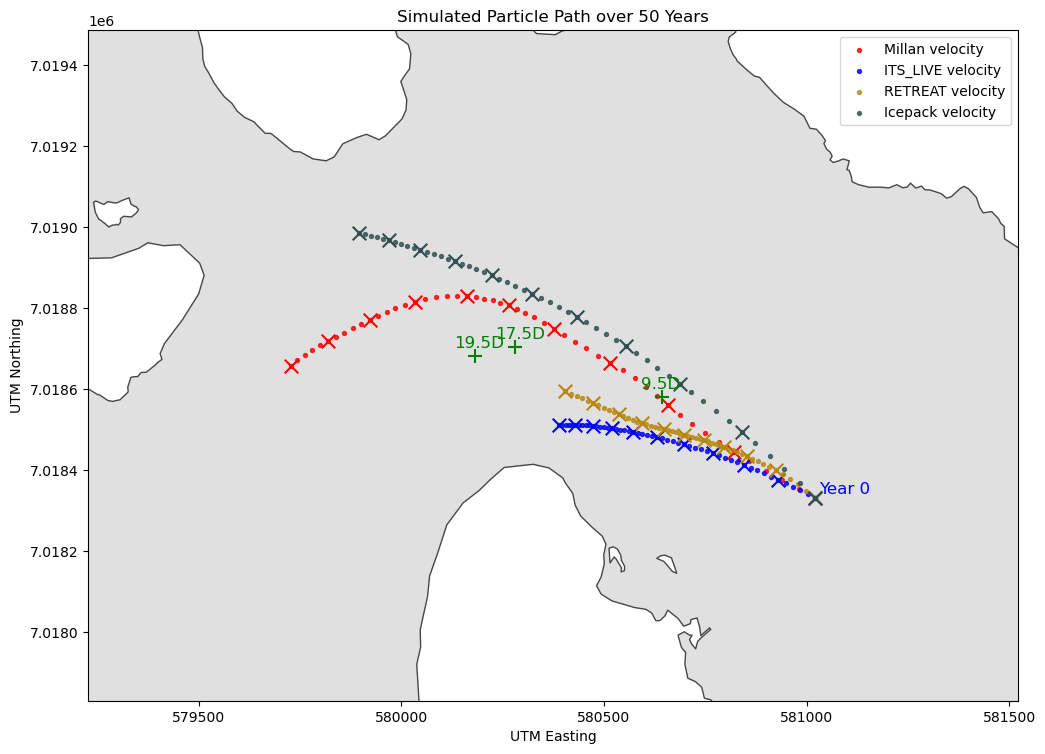

Note: every 5 years is marked by an X.
Long-term stake positions are plotted in green. Annotations describe the stake name and year since initial placement.


In [16]:
# Plot the path of the point through time on top of the glacier outline
fig, ax = plt.subplots(figsize=(12, 12))
gpd.read_file(shp_file).plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)

# plot all results
for i, (vxplot, vyplot) in enumerate(coords_plot):
    ax.scatter(vxplot, vyplot, marker='o', color=colors[i], s=8, alpha=0.8, label=labels[i]+' velocity')
    for j in range(len(vxplot)):
        if j % 5 == 0:
            ax.scatter(vxplot[j], vyplot[j], marker='x', color=colors[i], s=96)

# plot the USGS stake data
if plot_test_site:
    for tsite in test_sites:
        tsite_yr = (tsite[0] - tsite[2]) # time elapsed since installation (add 0.5 year for fall)
        if tsite[1] == 'Fall':
            tsite_yr += 0.5
            
        ax.scatter(tsite[5], tsite[6], s=96, marker='+', color='g')
        ax.annotate(str(tsite_yr) + tsite[3], (tsite[5]-50, tsite[6]+20), color='g', fontsize=12)

# annotate the starting point
ax.annotate('Year 0', (coords_plot[0][0][0]+10, coords_plot[0][1][0]+10), color='b', fontsize=12) 

# setup remaining plot
ax.set_xlim([min(min(a) for a in coords_plot_vx)-500, max(max(a) for a in coords_plot_vx)+500])
ax.set_ylim([min(min(a) for a in coords_plot_vy)-500, max(max(a) for a in coords_plot_vy)+500])
ax.set_xlabel('UTM Easting')
ax.set_ylabel('UTM Northing')
ax.set_title('Simulated Particle Path over ' + str(tot_time[-1]) + ' Years')
ax.legend()
plt.show()

print('Note: every 5 years is marked by an X.\nLong-term stake positions are plotted in green.' + 
      ' Annotations describe the stake name and year since initial placement.')


In [17]:
# smoothing seems to simply reduce the flowpath length--this is not surprising.
# velocity pathway is best with Millan data; how does velFlowlineOutline pathway do?


### Remove newly created files

In [18]:
os.remove(smooth_vx_fp)
os.remove(smooth_vy_fp)
